In [8]:
# Referenced from https://github.com/DL4mHealth/COMET/blob/main/data_preprocessing/PTB/PTB_preprocessing.ipynb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datautils import normalize, resample, R_Peaks, trial2sample, sample2trial

In [2]:
# specify the unziped data path and diagnostics file path
data_path = '../ECGDataDenoised'
meta_path = '../ECGDataDenoised/Diagnostics.xlsx'

In [3]:
meta = pd.read_excel(meta_path)

In [4]:
records_name = meta['FileName'].values
len(records_name)

10646

In [5]:
meta['Rhythm'].value_counts()

Rhythm
SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: count, dtype: int64

In [6]:
# group the rhythms into 4 classes
label_dict = {'SB': 0, # SB
              'AFIB': 1, 'AF': 1, # AF
              'ST': 2, 'SVT': 2, 'AT': 2, 'AVNRT': 2, 'AVRT': 2, 'SAAWR': 2, # GSVT
              'SR': 3, 'SA': 3} # SR
labels = meta[['FileName', 'Rhythm']].replace(label_dict)

/tmp/ipykernel_1818/1605392479.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels = meta[['FileName', 'Rhythm']].replace(label_dict)


In [7]:
# get median R-Peak intervals for all trials, drop trials that contains nan or all zero
med_intervals = []
nan_trial = []
allzero_trial = []
abnormal_trial = []
for record in os.listdir(data_path):
    if record.endswith('.csv'):
        ecg_data = pd.read_csv(os.path.join(data_path, record), header=None).values
        if np.all(ecg_data == 0):
            allzero_trial.append(record)
            print(f'All zero: {record}')
            continue
        if np.any(np.isnan(ecg_data)):
            nan_trial.append(record)
            print(f'Nan: {record}')
            continue
        trial = []
        for ch in range(ecg_data.shape[1]):
            trial.append(resample(ecg_data[:, ch], freq1=500, freq2=250, kind='linear'))
        trial = np.array(trial).T
        trial_norm = normalize(trial)
        try:
            _, med, _ = R_Peaks(trial_norm)
            med_intervals.append(med.to_list())
        except IndexError:
            abnormal_trial.append(record)
            print(f'IndexError: {record}')

print(len(nan_trial), len(allzero_trial), len(abnormal_trial))
new_records_name = [r for r in records_name if r+'.csv' not in nan_trial + allzero_trial + abnormal_trial]
print(len(new_records_name))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

All zero: MUSE_20181222_204243_08000.csv
All zero: MUSE_20181222_204157_58000.csv
All zero: MUSE_20181222_204236_34000.csv
All zero: MUSE_20181222_204249_88000.csv
All zero: MUSE_20181222_204222_63000.csv
Nan: MUSE_20180113_180425_75000.csv
All zero: MUSE_20181222_204217_03000.csv
All zero: MUSE_20181222_204154_20000.csv
Nan: MUSE_20180712_151351_36000.csv
All zero: MUSE_20181222_204240_84000.csv
All zero: MUSE_20181222_204248_77000.csv
All zero: MUSE_20181222_204226_00000.csv
All zero: MUSE_20181222_204245_36000.csv
Nan: MUSE_20180712_152022_92000.csv
All zero: MUSE_20181222_204122_52000.csv
All zero: MUSE_20181222_204156_45000.csv
All zero: MUSE_20181222_204118_08000.csv
Nan: MUSE_20180119_174843_24000.csv
All zero: MUSE_20181222_204155_31000.csv
All zero: MUSE_20181222_204140_77000.csv
All zero: MUSE_20181222_204310_31000.csv
All zero: MUSE_20181222_204212_44000.csv
All zero: MUSE_20181222_204314_78000.csv
Nan: MUSE_20180210_130454_71000.csv
All zero: MUSE_20181222_204219_27000.csv


In [11]:
# 9713 records suitable for analysis
med_all = df_med_intervals.median()
print(med_all[med_all <= 300].shape)
print(med_all[med_all <= 300].max())
max_duration = 300

((9713,), 300.0)

In [12]:
# remove records that have median interval length greater than max duration
med_intervals = []
abnormal_trial = []
med_nan_trial = []
for record in new_records_name:
    ecg_data = pd.read_csv(os.path.join(data_path, record+'.csv'), header=None).values
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=500, freq2=250, kind='linear'))
    trial = np.array(trial).T
    trial_norm = normalize(trial)
    try:
        _, med, _ = R_Peaks(trial_norm)
        if med.median() <= max_duration:
            if np.any(np.isnan(med)):
                med_nan_trial.append(record)
                print(f'Med Nan: {record}')
                continue
            med_intervals.append(med.to_list())
        else:
            abnormal_trial.append(record)
            print(f'Outlider: {record}')
    except IndexError:
        abnormal_trial.append(record)
        print(f'IndexError: {record}')
        
print(len(abnormal_trial), len(med_nan_trial))
final_records_name = [r for r in new_records_name if r not in abnormal_trial + med_nan_trial]
print(len(final_records_name))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

Med Nan: MUSE_20180712_160448_42000
Outlider: MUSE_20180112_133006_47000
Outlider: MUSE_20180112_072033_34000
Outlider: MUSE_20180114_121113_24000
Outlider: MUSE_20180115_130426_87000
Outlider: MUSE_20180116_130643_35000
Med Nan: MUSE_20180113_135710_28000
Outlider: MUSE_20180111_163357_09000
Outlider: MUSE_20180113_124658_83000
Outlider: MUSE_20180114_133820_34000
Med Nan: MUSE_20180210_131459_59000
Outlider: MUSE_20180113_173554_96000
Outlider: MUSE_20180112_071514_26000
Outlider: MUSE_20180118_131733_19000
Outlider: MUSE_20180113_125103_10000
Outlider: MUSE_20180116_122520_49000
Outlider: MUSE_20180118_125800_75000
Outlider: MUSE_20180118_122906_36000
Outlider: MUSE_20180112_075437_85000
Outlider: MUSE_20180115_124332_88000
Med Nan: MUSE_20180118_132425_03000
Outlider: MUSE_20180112_124231_23000
Outlider: MUSE_20180114_072231_70000
Outlider: MUSE_20180712_153518_42000
Med Nan: MUSE_20180115_123200_57000
Outlider: MUSE_20180113_134104_50000
Outlider: MUSE_20180118_120854_33000
Outlid

In [16]:
# main
feature_path = '../dataset/chapman/feature'
if not os.path.exists(feature_path):
    os.makedirs(feature_path)
    
dict_label = {}
sub_id = 1
for record in final_records_name:
    label = labels[labels['FileName']==record]['Rhythm'].values[0]
    dict_label[sub_id] = label
    ecg_data = pd.read_csv(os.path.join(data_path, record+'.csv'), header=None).values
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=500, freq2=250, kind='linear'))
    trial = np.array(trial).T
    trial_norm = normalize(trial)
    samples = trial2sample(trial_norm, max_duration=300) # segment and pad
    segmentations = sample2trial(samples, size=6) # regroup
    
    if segmentations != list():
        segmentations = np.array(segmentations)
        print(segmentations.shape)
        np.save(os.path.join(feature_path, f'feature_{sub_id:05d}'), segmentations)
        sub_id += 1    
    else:
        print(f'The subject is None after preprocessing: {record}')  

(3, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(4, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(4, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(2, 1800, 12)
(2, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 1800, 12)
(3, 1800, 12)
(1, 1800, 12)
(2, 1800, 12)
(1, 18

In [17]:
len(dict_label)

9713

In [18]:
label_path = '../data/chapman/label'
if not os.path.exists(label_path):
    os.makedirs(label_path)

df_label = pd.DataFrame([dict_label]).T
df_label = df_label.reset_index().astype('int64')
labels = df_label[[0, 'index']].values
np.save(os.path.join(label_path, 'label'), labels)

In [6]:
# test
sig = np.load('../dataset/chapman/feature/feature_01000.npy')
sig

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], shape=(2, 1800, 12))

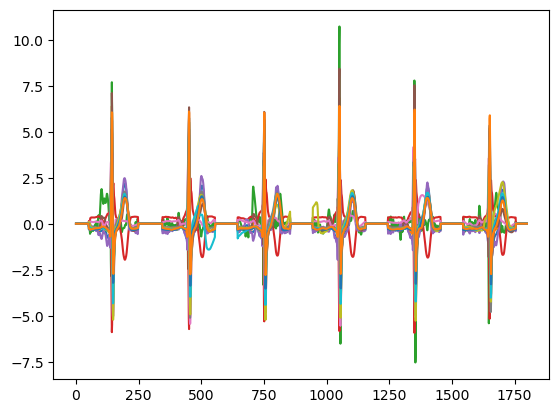

In [10]:
plt.plot(sig[0])

In [11]:
np.load('../dataset/chapman/label/label.npy')

array([[   1,    1],
       [   0,    2],
       [   3,    3],
       ...,
       [   2, 9711],
       [   2, 9712],
       [   2, 9713]], shape=(9713, 2))